## Imports

In [1]:
import originpro as op
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import os

## Data Loading

In [2]:
df_dict = {}
for file in os.listdir('data'):
    full_path = f"data/{file}"
    if full_path[-4:] != "xlsx": continue
    df = pd.read_excel(full_path)
    df_dict[file[:-5]] = df

In [3]:
mag_field_dict = {}
df = pd.read_excel("data/magnetic_field_strengths.xlsx")
for col in df.columns:
    mag_field_dict[col] = df[col].to_numpy()[1:]

## Data Analysis

### Functions

In [187]:
peak_err = 0.002 ##Error in peak positions, seen by inspection
peak_split_err = peak_err * np.sqrt(2) ##Error in 2 peak splitting, by propogation of errors
SPLITTING_CONST = 4.668 * (10 ** -8)
HALF_RESOLUTION = 0.0073  ##Half width at half max due to instrumental resolution

initial_peak_dist = 0.03  ##Starting guess for distance between peaks
initial_width = 0.01  ##Starting guess for peak width
initial_height = 100  ##Starting guess for baseline counts

In [61]:
def single_lorentzian(x, A1, x01, gamma1, c):
    return A1 / (1 + ((x - x01) / gamma1) ** 2) + c

def fit_single_lorentzian(wavelengths, counts, initial_center):
    initial_guess = [np.max(counts), initial_center, initial_width, initial_height] 
    params, covariance = curve_fit(single_lorentzian, 
                                       wavelengths, 
                                       counts, 
                                       p0=initial_guess)
    return params
    

def double_lorentzian(x, A1, x01, gamma1, A2, x02, gamma2, c):
    return (
        A1 / (1 + ((x - x01) / gamma1) ** 2) +
        A2 / (1 + ((x - x02) / gamma2) ** 2) + c
    )

def multiple_lorentzian(x, A_list, x01_list, gamma_list):
    """
    Calculate multiple overlayed lorentzians over x values
    """
    y_vals = np.zeros(len(x))
    for A1, x01, gamma1 in zip(A_list, x01_list, gamma_list):
        y_vals += single_lorentzian(x, A1, x01, gamma1, 0)
    return y_vals

def linear_func(x, m, b):
    y = m * x + b
    return y


In [62]:
def get_peak_splitting(file_name, initial_center,):
    """
    Calculate the splitting of double peaked data based on lorentzian fitting
    """
    wavelengths, counts = extract_data(file_name)
    A1, x01, gamma1, A2, x02, gamma2, c = fit_double_lorentzian(wavelengths, counts, initial_center)
    return np.abs(x02 - x01)

def calculate_g_eff(m, m_err, wavelength):
    return (m / (2 * SPLITTING_CONST * wavelength ** 2),
            m_err / (2 * SPLITTING_CONST * wavelength ** 2))

def get_theoretical_peak(wavelength, mag_field, geff):
    return wavelength + SPLITTING_CONST * geff * mag_field * wavelength**2
    
def get_theoretical_peaks(wavelength, mag_field, geff_list):
    """
    Get the expected positions of the peaks for a given wavelength, magnetic field, and geff list
    """
    return [get_theoretical_peak(wavelength, mag_field, geff) for geff in geff_list]
    

In [188]:
def fit_double_lorentzian(wavelengths, counts, initial_center):
    """
    Fit double lorentzian to wavelengths, counts data
    Return fit parameters
    """
    initial_guess = [np.max(counts), 
                     initial_center - initial_peak_dist / 2, 
                     initial_width, 
                     np.max(counts), 
                     initial_center + initial_peak_dist / 2, 
                     initial_width,
                     initial_height] 
    params, covariance = curve_fit(double_lorentzian, 
                                       wavelengths, 
                                       counts, 
                                       p0=initial_guess)
    return params

def extract_data(file_name):
    df = df_dict[file_name]
    return df['wavelength'], df['counts']

def plot_fit(wavelengths, counts, initial_center, ax, double = False):
    """
    Plot a lorentzian fit
    """
    if not double:
        A1, x01, gamma1, c = fit_single_lorentzian(wavelengths, counts, initial_center)
        ax.plot(wavelengths, single_lorentzian(wavelengths, A1, x01, gamma1, c), 'r', label = "Fit to Data")
    if double:
        A1, x01, gamma1, A2, x02, gamma2, c = fit_double_lorentzian(wavelengths, counts, initial_center)
        ax.plot(wavelengths, double_lorentzian(wavelengths, A1, x01, gamma1, A2, x02, gamma2, c), 'r', label = "Fit to Data")

def plot_theory(wavelengths, counts, center, mag_field, geff_list, intensity_list, ax):
    """
    Plot simulation data
    """
    peaks = get_theoretical_peaks(center, mag_field, geff_list)
    intensities = multiple_lorentzian(wavelengths, intensity_list, peaks, [HALF_RESOLUTION] * len(peaks))
    ##Normalize the intensities to match counts
    intensities *= np.sum(counts) / np.sum(intensities)
    ax.plot(wavelengths, intensities, color = "black", label = "Simulated")

#Line of best fit calculation
def fit_line(mag_fields, peak_splittings):
    """
    Fit a line to data, and return m, b, and error of m and b
    """
    splitting_errors = np.full(len(peak_splittings), peak_split_err)
    params,cov=curve_fit(linear_func,
                        mag_fields,
                        peak_splittings,
                        sigma=splitting_errors,
                        absolute_sigma=True)
    m, b = params
    m_err, b_err = np.sqrt(cov[0, 0]), np.sqrt(cov[1, 1])
    return m, b, m_err, b_err

def plot_line_fit(mag_fields, peak_splittings, wavelength, ax):
    """
    Plot line fit with errors, display g effective
    """
    m, b, m_err, _ = fit_line(mag_fields, peak_splittings)

    splitting_errors = np.full(len(peak_splittings), peak_split_err)
    ax.errorbar(mag_fields, 
                peak_splittings, 
                splitting_errors, 
                fmt = 'o', 
                ecolor = "black", 
                capsize= 4,
                label = "Splitting")
    x_vals = np.linspace(np.min(mag_fields), 
                         np.max(mag_fields), 
                         100)
    y_vals = linear_func(x_vals, m, b)
    ax.plot(x_vals, y_vals, color = "red", label = "Line of Best Fit")

### 404.7 nm Hg line

In [85]:
wavelength = 404.7
el = "Hg"

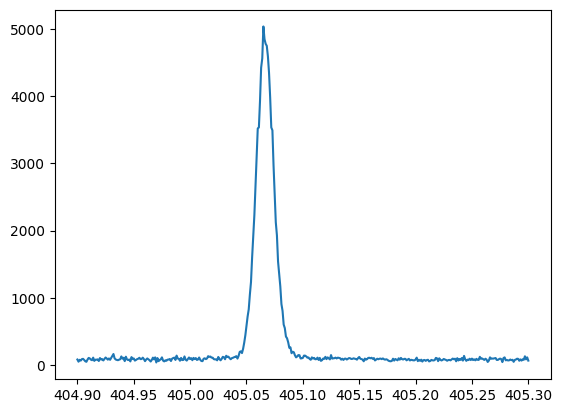

In [86]:
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
plt.plot(wavelengths, counts)

Text(0.5, 0.98, 'Hg 404.7 nm Pi Lines')

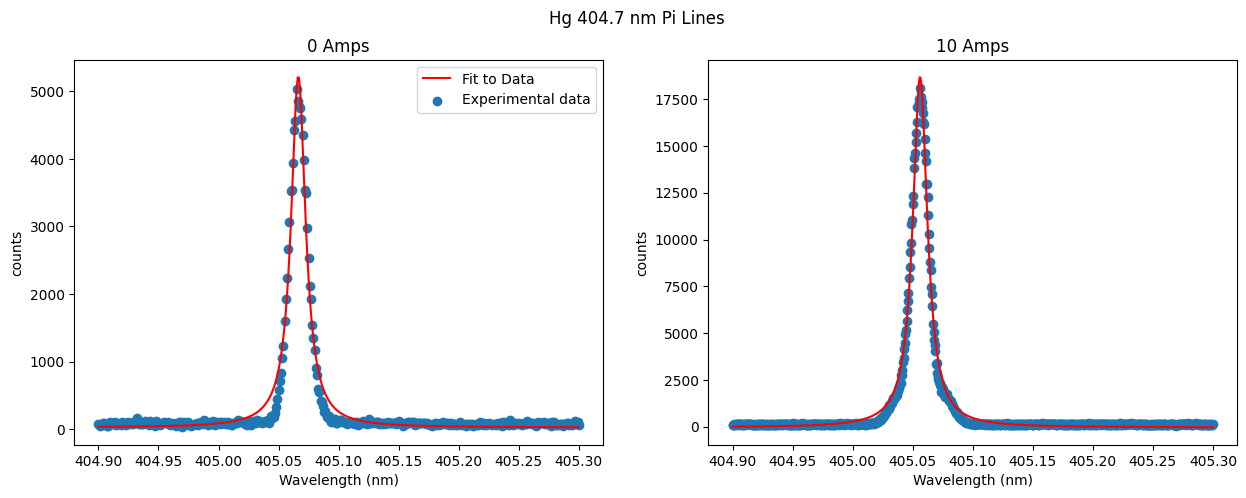

In [132]:
## Fits at 0 and 10 amps for pi polarization
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
plot_fit(wavelengths, counts, 405.06, axes[0], double = False)
axes[0].scatter(wavelengths, counts, label = "Experimental data")
axes[0].set_ylabel("counts")
axes[0].set_xlabel("Wavelength (nm)")
axes[0].set_title("0 Amps")

wavelengths, counts = extract_data(f"{el}_10amp_{wavelength}pi")
plot_fit(wavelengths, counts, 405.06, axes[1], double = False)
axes[1].scatter(wavelengths, counts, label = "Experimental data")
axes[1].set_ylabel("counts")
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_title("10 Amps")
axes[0].legend()

plt.suptitle(f"{el} {wavelength} nm Pi Lines")

Text(0.5, 0.98, 'Hg 404.7 nm Sigma Lines')

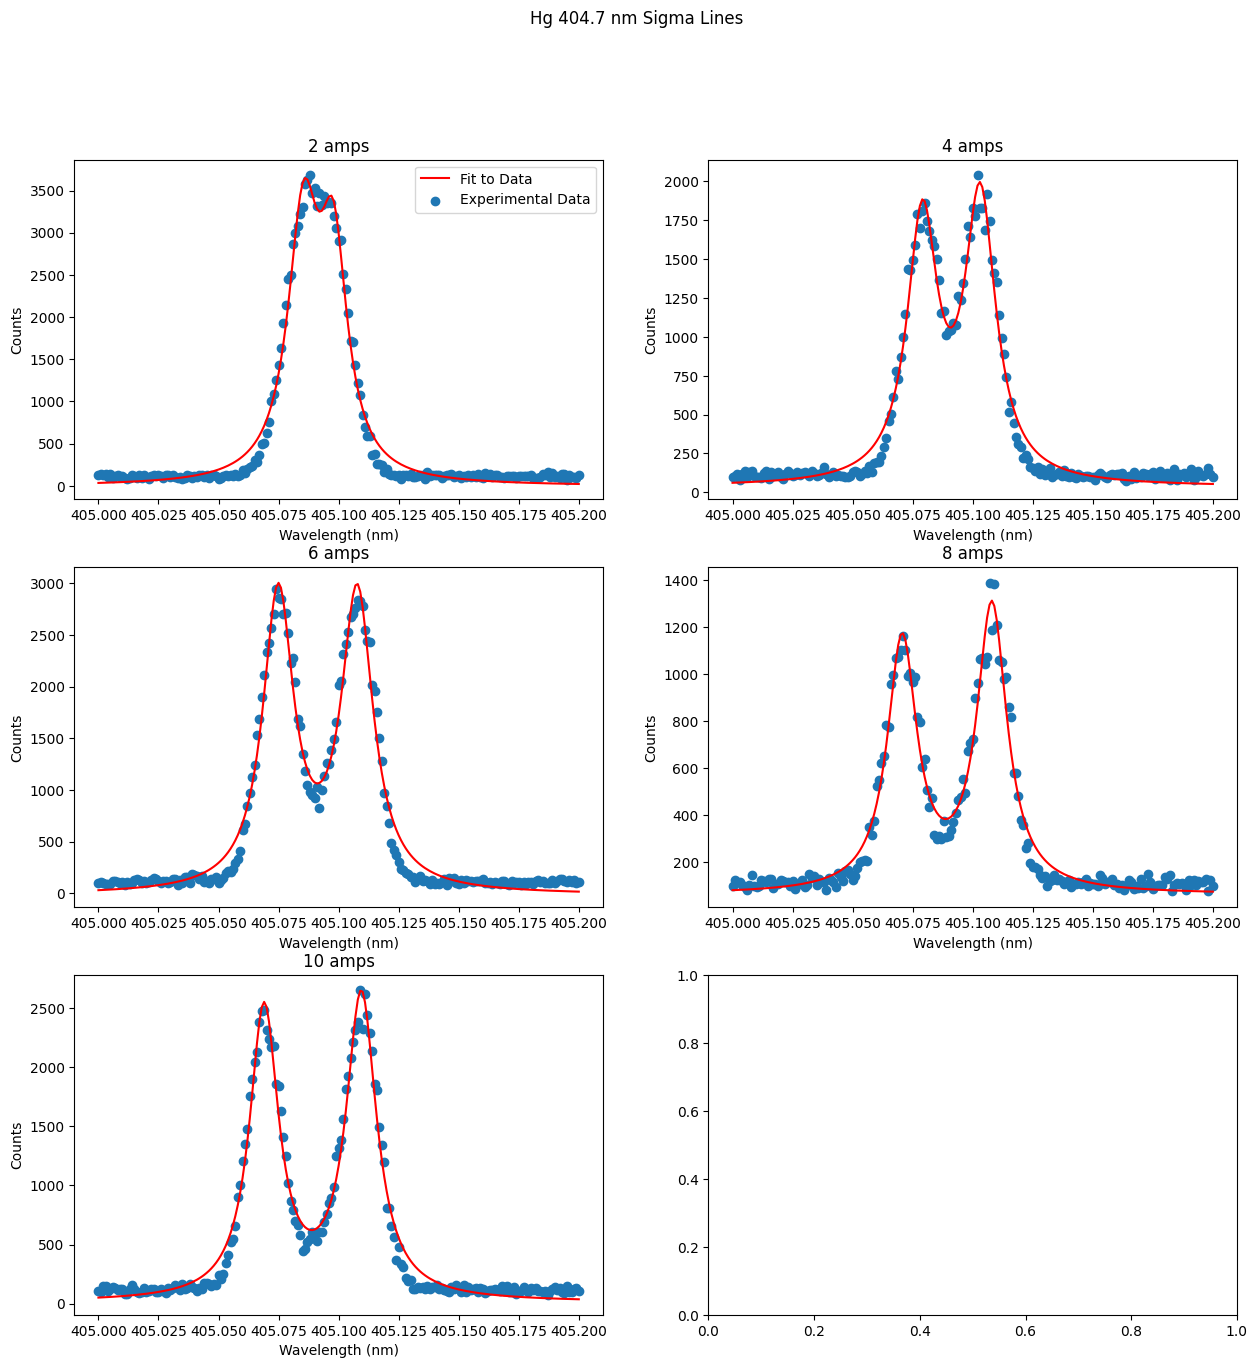

In [133]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
currents = np.around(np.arange(2, 12, 2))
initial_center = 405.09
peak_splittings = []
for current, ax in zip(currents, axes.flatten()):
    file_name = f'{el}_{int(current)}amp_{wavelength}'
    wavelengths, counts = extract_data(file_name)
    plot_fit(wavelengths, counts, initial_center, ax, double = True)
    ax.scatter(wavelengths, counts, label = "Experimental Data")

    ax.set_ylabel("Counts")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_title(f"{current} amps")
    
    splitting = get_peak_splitting(file_name, initial_center)
    peak_splittings.append(splitting)

axes[0][0].legend()
plt.suptitle(f"{el} {wavelength} nm Sigma Lines")

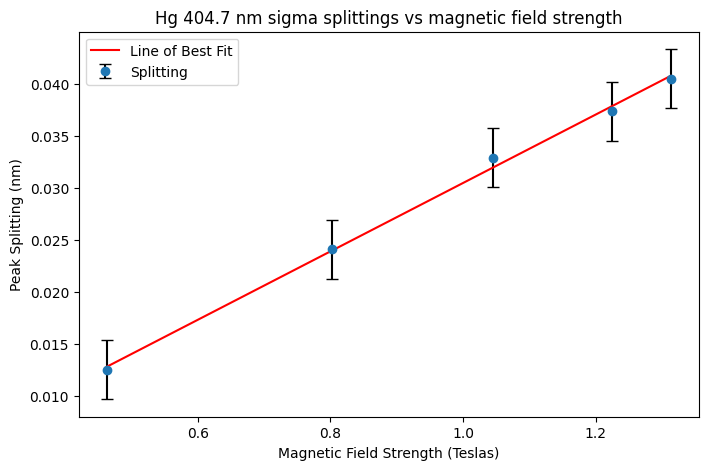

In [142]:
#Line of best fit calculation
mag_fields = mag_field_dict[f"{el}_{wavelength}"]
fig, ax = plt.subplots(figsize = (8, 5))
plot_line_fit(mag_fields, peak_splittings, wavelength, ax)
ax.set_title(f"{el} {wavelength} nm sigma splittings vs magnetic field strength")
ax.set_ylabel("Peak Splitting (nm)")
ax.set_xlabel("Magnetic Field Strength (Teslas)")
ax.legend()

In [146]:
m, b, m_err, _ = fit_line(mag_fields, peak_splittings)
geff, err = calculate_g_eff(m, m_err, wavelength)
print(f"geff: {geff} +/- {err}")

geff: 2.147724796174021 +/- 0.26903723251166084


The actual g effective for this is 2!!!

### 435.8 Hg Line

In [147]:
wavelength = 435.8
el = "Hg"
mag_fields = mag_field_dict[f"{el}_{wavelength}"]

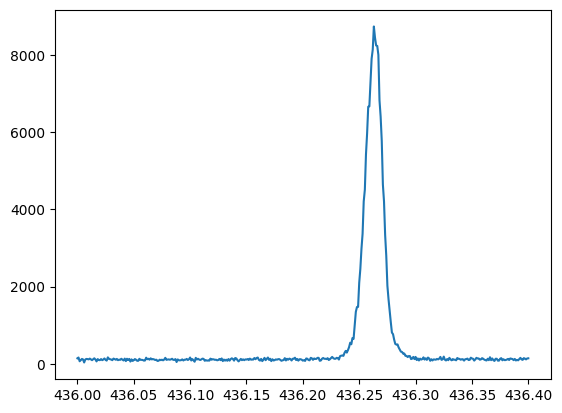

In [148]:
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
plt.plot(wavelengths, counts)

Text(0.5, 0.98, 'Hg 435.8 nm Pi Lines')

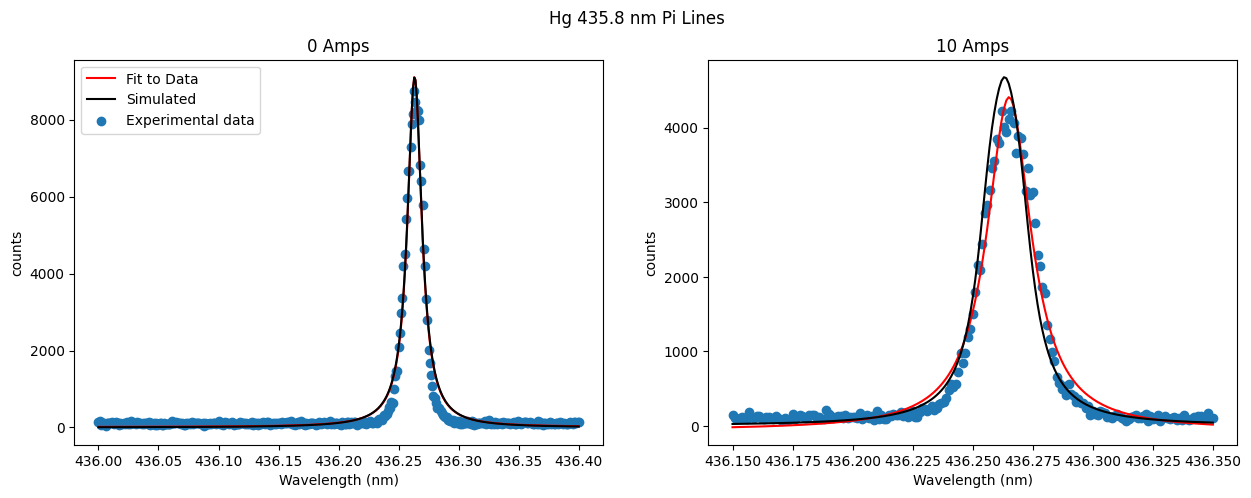

In [157]:
## Fits at 0 and 10 amps for pi polarization
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
A1, x01, gamma1, c = fit_single_lorentzian(wavelengths, counts, 436.27)

plot_fit(wavelengths, counts, 436.27, axes[0], double = False)
plot_theory(wavelengths, 
            counts,
            x01,
            mag_fields[-1],
            geff_list = [0],
            intensity_list = [16],
            ax = axes[0])
axes[0].scatter(wavelengths, counts, label = "Experimental data")
axes[0].set_ylabel("counts")
axes[0].set_xlabel("Wavelength (nm)")
axes[0].set_title("0 Amps")

wavelengths, counts = extract_data(f"{el}_10amp_{wavelength}pi")
plot_fit(wavelengths, counts, 436.27, axes[1], double = False)
plot_theory(wavelengths, 
            counts,
            x01,
            mag_fields[-1],
            geff_list = [-0.5, 0, 0.5],
            intensity_list = [12, 16, 12],
            ax = axes[1])
axes[1].scatter(wavelengths, counts, label = "Experimental data")
axes[1].set_ylabel("counts")
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_title("10 Amps")
axes[0].legend()

plt.suptitle(f"{el} {wavelength} nm Pi Lines")

Text(0.5, 0.98, 'Hg 435.8 nm Sigma Lines')

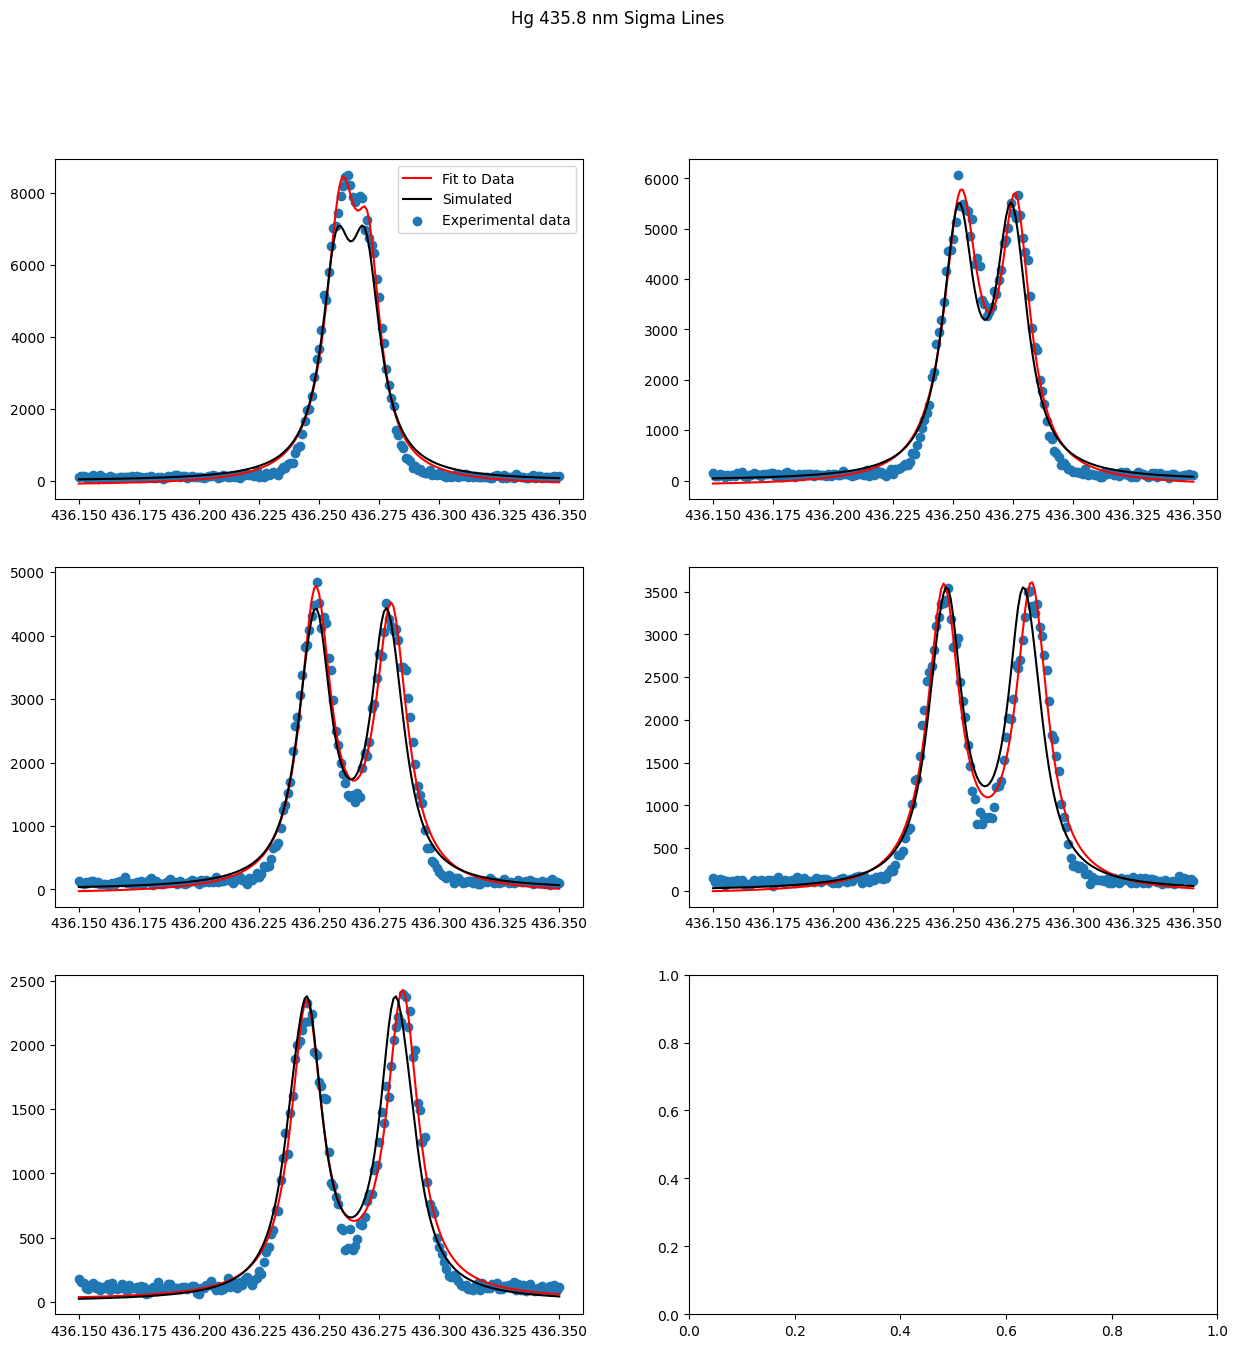

In [160]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
currents = np.around(np.arange(2, 12, 2))
initial_center = 436.26
peak_splittings = []
for current, ax, mag_field in zip(currents, axes.flatten(), mag_fields):
    file_name = f'{el}_{int(current)}amp_{wavelength}'
    wavelengths, counts = extract_data(file_name)
    plot_fit(wavelengths, 
             counts, 
             initial_center, 
             ax, 
             double = True)
    splitting = get_peak_splitting(file_name, initial_center)
    plot_theory(wavelengths = wavelengths, 
                counts = counts,
                center = x01,
                mag_field = mag_field,
                geff_list = [-2.0, -1.5, 1.5, 2.0],
                intensity_list = [2, 6, 6, 2],
                ax = ax)

    ax.scatter(wavelengths, counts, label = "Experimental data")
    peak_splittings.append(splitting)

axes[0][0].legend()
plt.suptitle(f"{el} {wavelength} nm Sigma Lines")

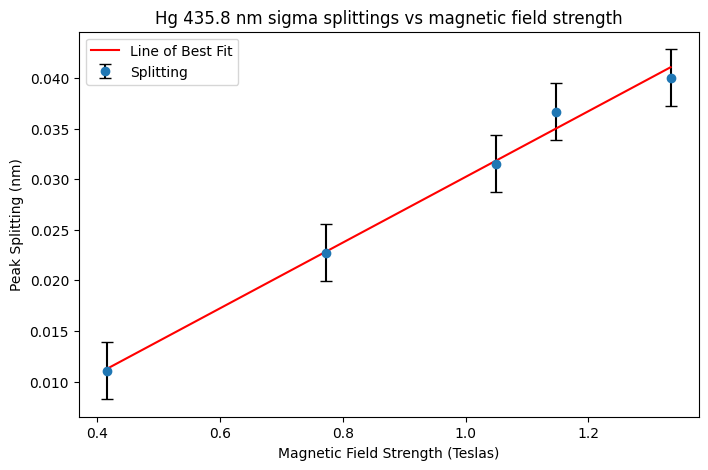

In [161]:
#Line of best fit calculation
mag_fields = mag_field_dict[f"{el}_{wavelength}"]
fig, ax = plt.subplots(figsize = (8, 5))
plot_line_fit(mag_fields, peak_splittings, wavelength, ax)
ax.set_title(f"{el} {wavelength} nm sigma splittings vs magnetic field strength")
ax.set_ylabel("Peak Splitting (nm)")
ax.set_xlabel("Magnetic Field Strength (Teslas)")
ax.legend()

In [162]:
m, b, m_err, _ = fit_line(mag_fields, peak_splittings)
geff, err = calculate_g_eff(m, m_err, wavelength)
print(f"geff: {geff} +/- {err}")

geff: 1.8307667901310092 +/- 0.22264636128460352


### 546.1 Hg Line

In [170]:
wavelength = 546.1
el = "Hg"
mag_fields = mag_field_dict[f"{el}_{wavelength}"]

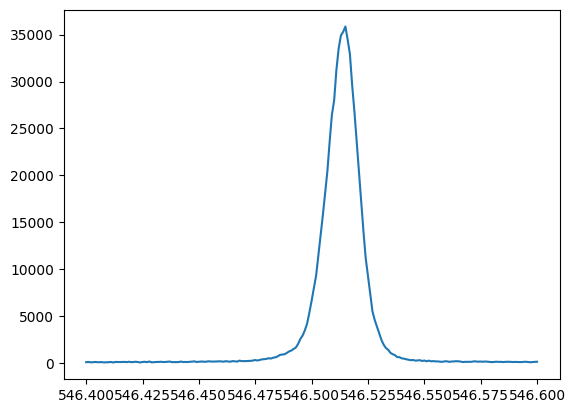

In [171]:
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
plt.plot(wavelengths, counts)

Text(0.5, 0.98, 'Hg 546.1 nm Pi Lines')

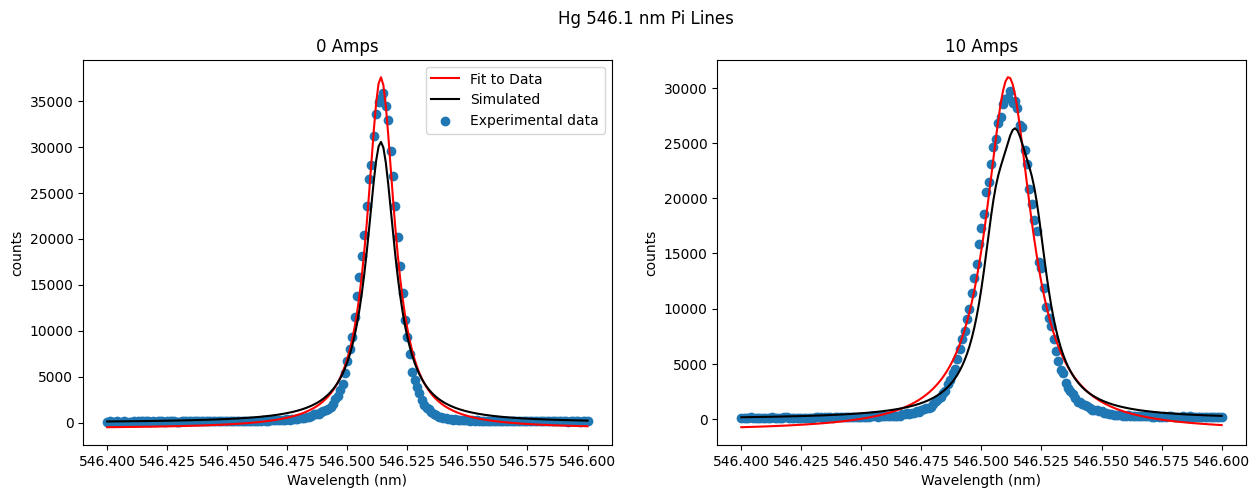

In [172]:
## Fits at 0 and 10 amps for pi polarization
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
A1, x01, gamma1, c = fit_single_lorentzian(wavelengths, counts, 546.51)

plot_fit(wavelengths, counts, 546.51, axes[0], double = False)
plot_theory(wavelengths, 
            counts,
            x01,
            mag_fields[-1],
            geff_list = [0],
            intensity_list = [16],
            ax = axes[0])
axes[0].scatter(wavelengths, counts, label = "Experimental data")
axes[0].set_ylabel("counts")
axes[0].set_xlabel("Wavelength (nm)")
axes[0].set_title("0 Amps")

wavelengths, counts = extract_data(f"{el}_10amp_{wavelength}pi")
plot_fit(wavelengths, counts, 546.51, axes[1], double = False)
plot_theory(wavelengths, 
            counts,
            x01,
            mag_fields[-1],
            geff_list = [-0.5, 0, 0.5],
            intensity_list = [12, 16, 12],
            ax = axes[1])
axes[1].scatter(wavelengths, counts, label = "Experimental data")
axes[1].set_ylabel("counts")
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_title("10 Amps")
axes[0].legend()

plt.suptitle(f"{el} {wavelength} nm Pi Lines")

Text(0.5, 0.98, 'Hg 546.1 nm Sigma Lines')

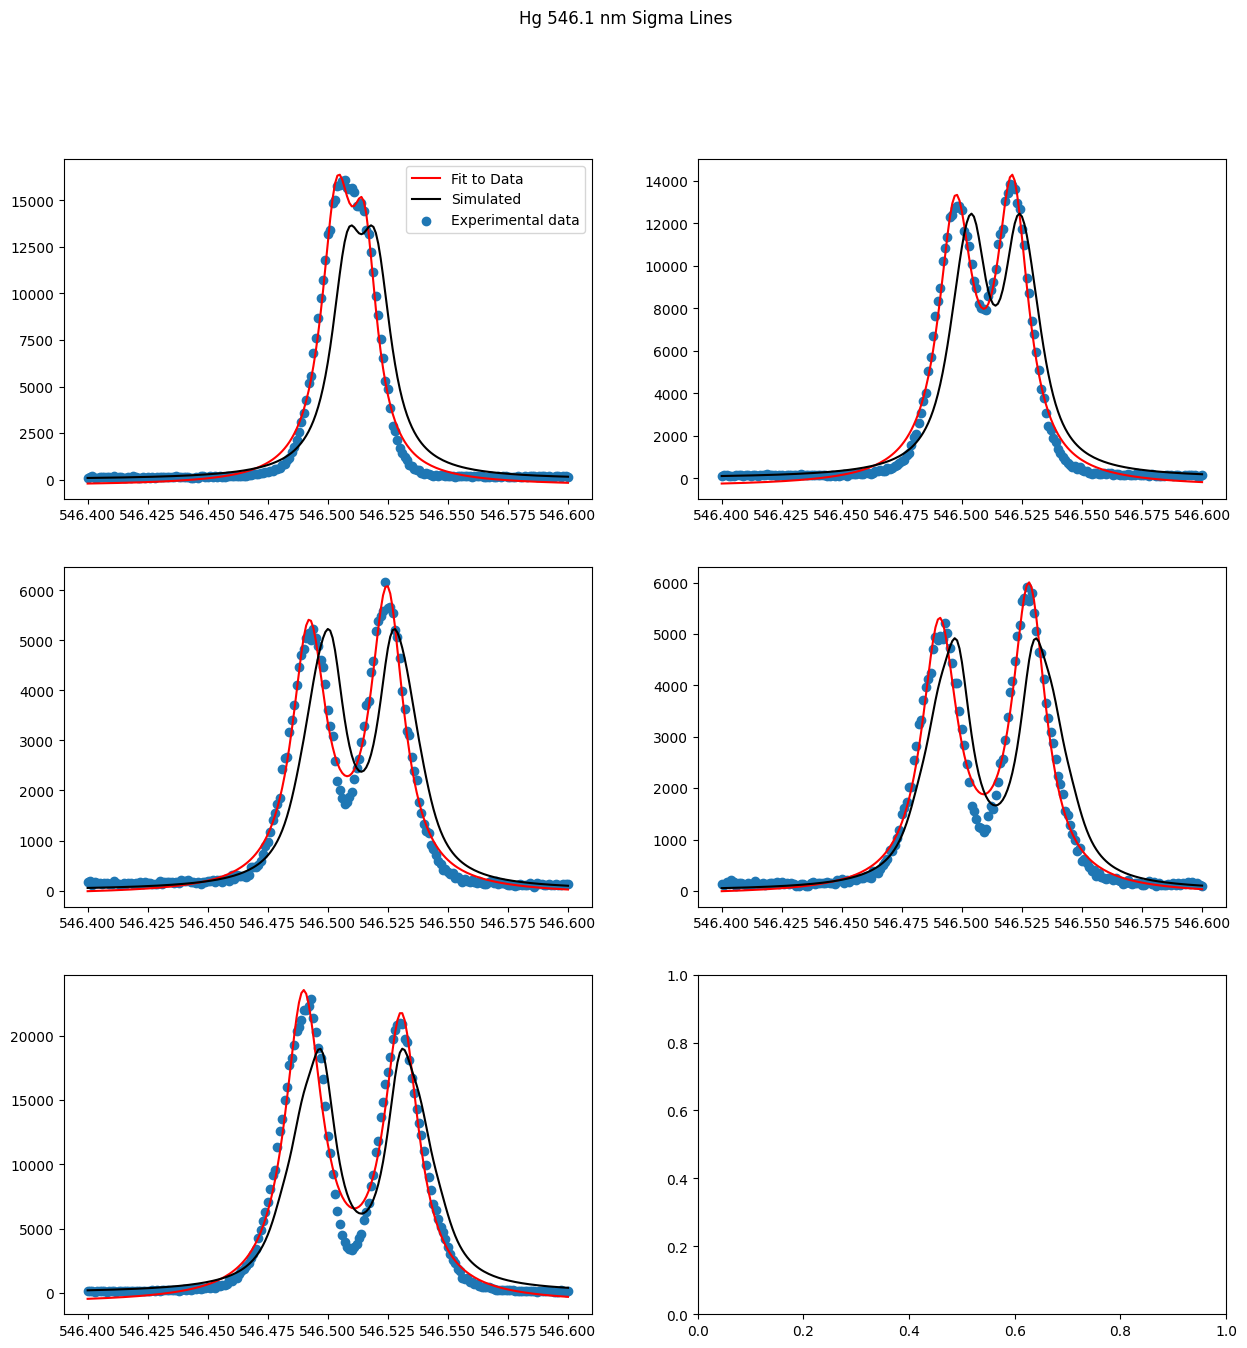

In [175]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
currents = np.around(np.arange(2, 12, 2))
initial_center = 546.51
peak_splittings = []
for current, ax, mag_field in zip(currents, axes.flatten(), mag_fields):
    file_name = f'{el}_{int(current)}amp_{wavelength}'
    wavelengths, counts = extract_data(file_name)
    plot_fit(wavelengths, 
             counts, 
             initial_center, 
             ax, 
             double = True)
    splitting = get_peak_splitting(file_name, initial_center)
    plot_theory(wavelengths = wavelengths, 
                counts = counts,
                center = x01,
                mag_field = mag_field,
                geff_list = [-2.0, -1.5, -1, 1, 1.5, 2.0],
                intensity_list = [2, 6, 12, 12, 6, 2],
                ax = ax)

    ax.scatter(wavelengths, counts, label = "Experimental data")
    peak_splittings.append(splitting)

axes[0][0].legend()
plt.suptitle(f"{el} {wavelength} nm Sigma Lines")

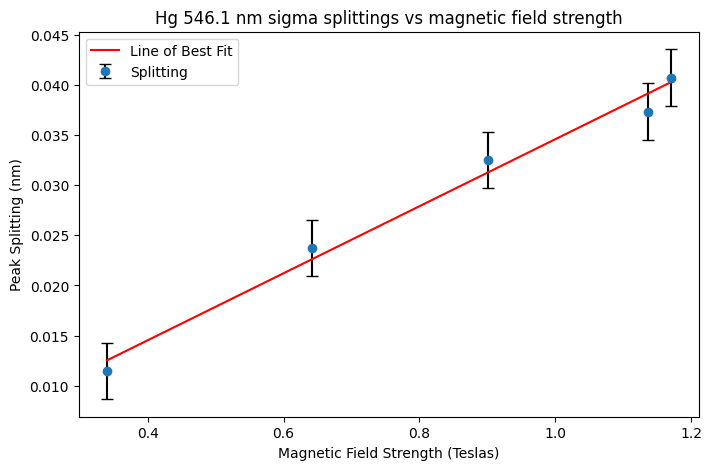

In [176]:
#Line of best fit calculation
mag_fields = mag_field_dict[f"{el}_{wavelength}"]
fig, ax = plt.subplots(figsize = (8, 5))
plot_line_fit(mag_fields, peak_splittings, wavelength, ax)
ax.set_title(f"{el} {wavelength} nm sigma splittings vs magnetic field strength")
ax.set_ylabel("Peak Splitting (nm)")
ax.set_xlabel("Magnetic Field Strength (Teslas)")
ax.legend()

In [177]:
m, b, m_err, _ = fit_line(mag_fields, peak_splittings)
geff, err = calculate_g_eff(m, m_err, wavelength)
print(f"geff: {geff} +/- {err}")

geff: 1.2001871346041233 +/- 0.14521126920398514


### Neon 585.3 Line

In [179]:
wavelength = 585.3
el = "Ne"

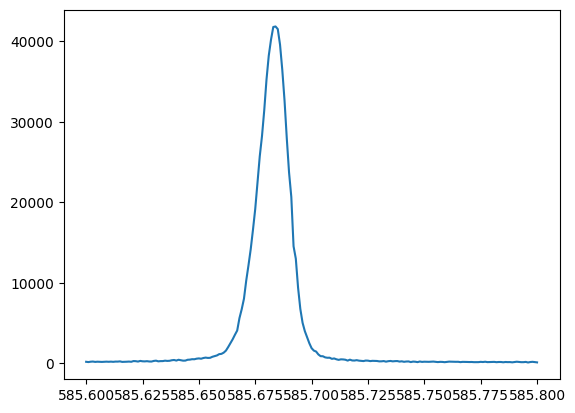

In [180]:
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
plt.plot(wavelengths, counts)

Text(0.5, 0.98, 'Ne 585.3 nm Pi Lines')

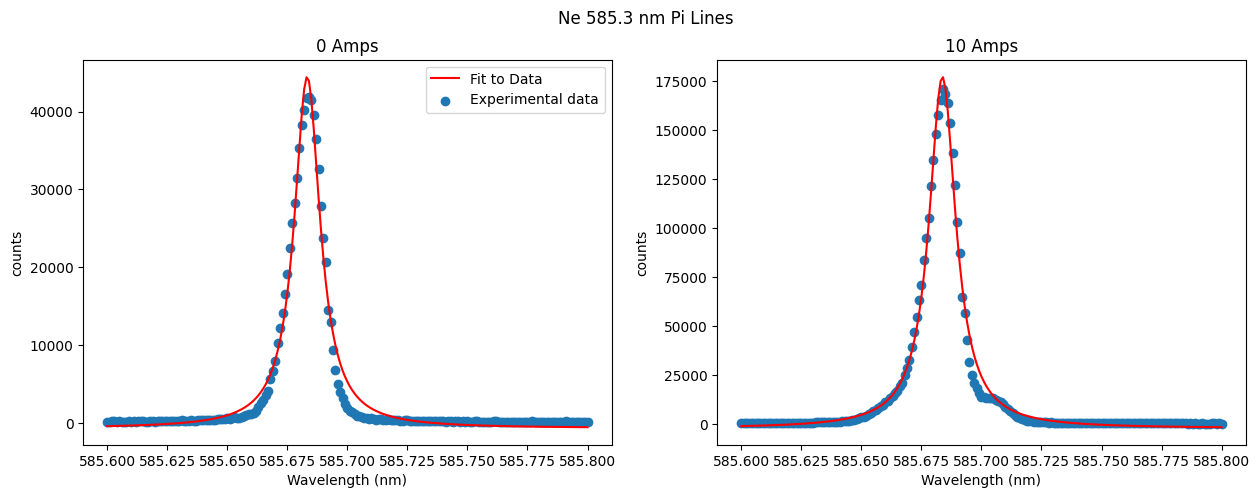

In [183]:
## Fits at 0 and 10 amps for pi polarization
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
wavelengths, counts = extract_data(f"{el}_0amp_{wavelength}pi")
plot_fit(wavelengths, counts, 585.677, axes[0], double = False)
axes[0].scatter(wavelengths, counts, label = "Experimental data")
axes[0].set_ylabel("counts")
axes[0].set_xlabel("Wavelength (nm)")
axes[0].set_title("0 Amps")

wavelengths, counts = extract_data(f"{el}_10amp_{wavelength}pi")
plot_fit(wavelengths, counts, 585.677, axes[1], double = False)
axes[1].scatter(wavelengths, counts, label = "Experimental data")
axes[1].set_ylabel("counts")
axes[1].set_xlabel("Wavelength (nm)")
axes[1].set_title("10 Amps")
axes[0].legend()

plt.suptitle(f"{el} {wavelength} nm Pi Lines")

Text(0.5, 0.98, 'Ne 585.3 nm Sigma Lines')

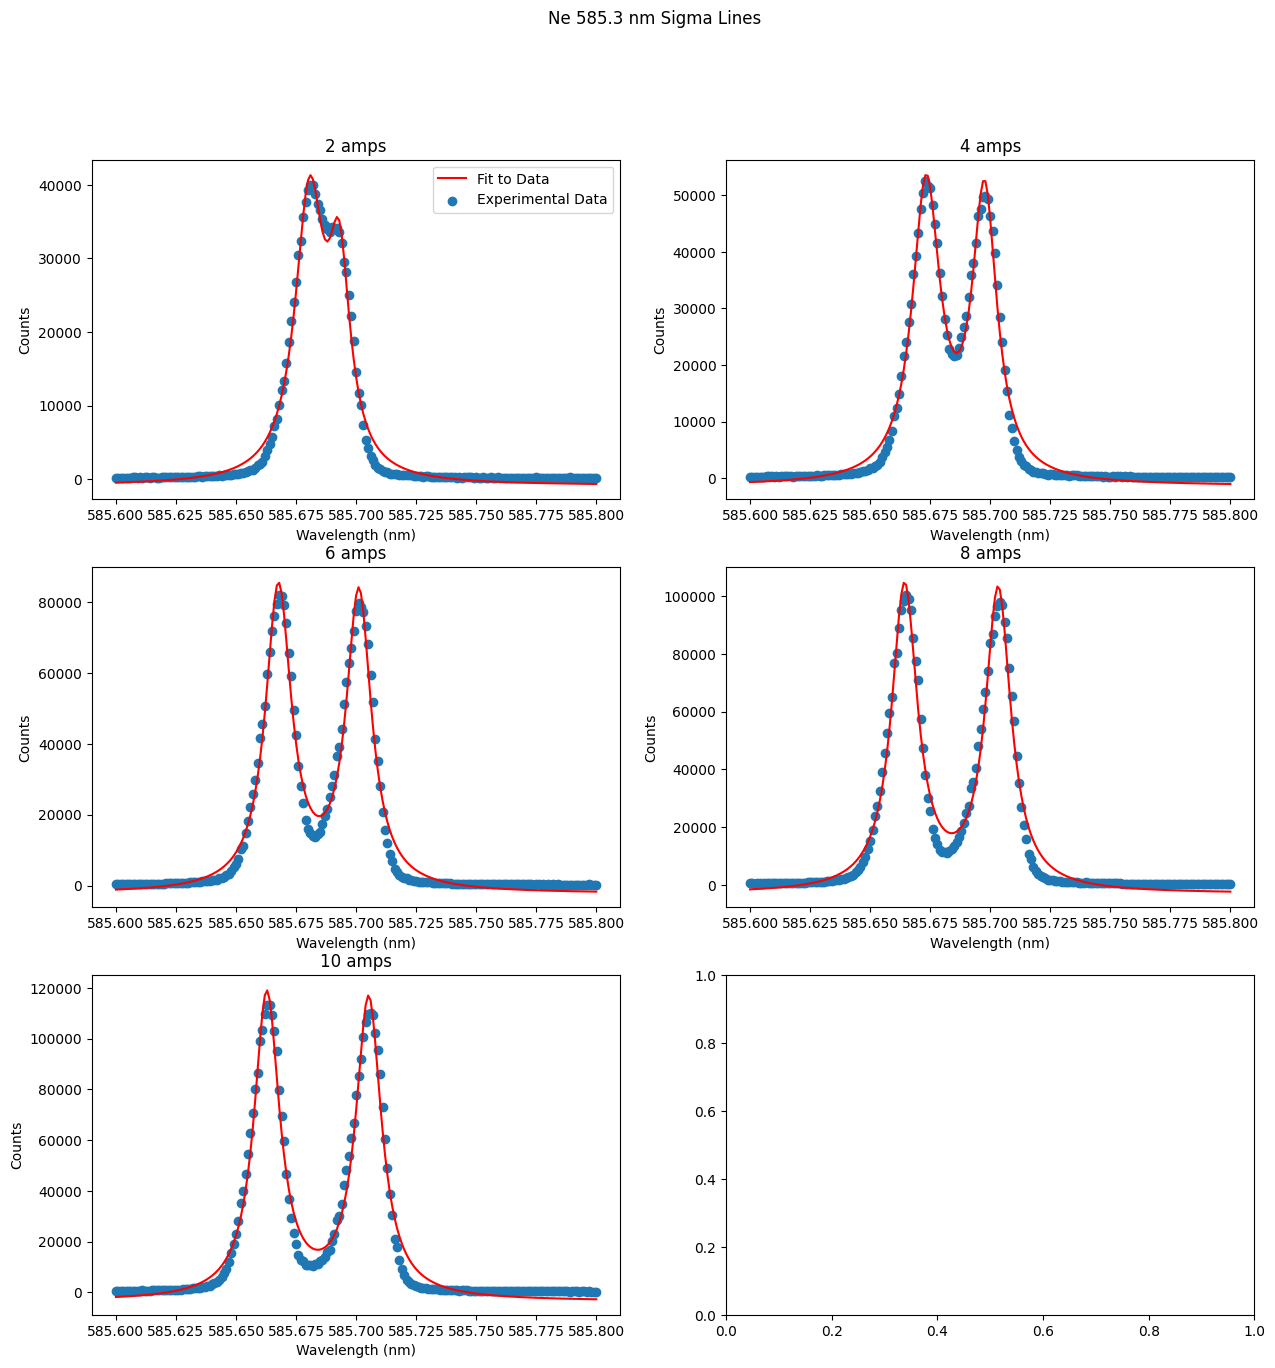

In [184]:
fig, axes = plt.subplots(3, 2, figsize = (15, 15))
currents = np.around(np.arange(2, 12, 2))
initial_center = 585.685
peak_splittings = []
for current, ax in zip(currents, axes.flatten()):
    file_name = f'{el}_{int(current)}amp_{wavelength}'
    wavelengths, counts = extract_data(file_name)
    plot_fit(wavelengths, counts, initial_center, ax, double = True)
    ax.scatter(wavelengths, counts, label = "Experimental Data")

    ax.set_ylabel("Counts")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_title(f"{current} amps")
    
    splitting = get_peak_splitting(file_name, initial_center)
    peak_splittings.append(splitting)

axes[0][0].legend()
plt.suptitle(f"{el} {wavelength} nm Sigma Lines")

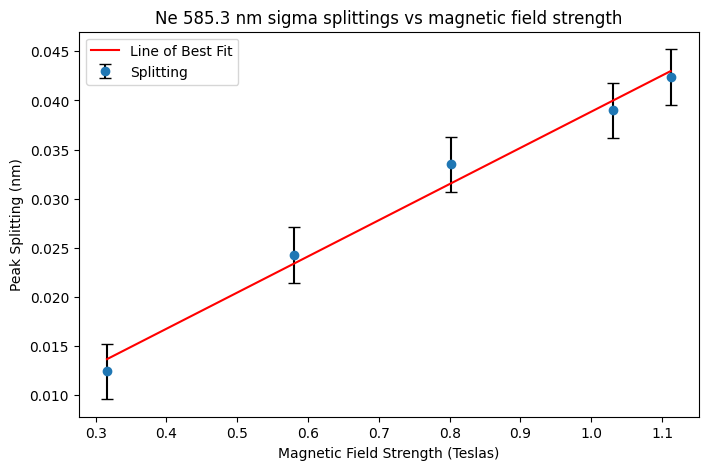

In [185]:
#Line of best fit calculation
mag_fields = mag_field_dict[f"{el}_{wavelength}"]
fig, ax = plt.subplots(figsize = (8, 5))
plot_line_fit(mag_fields, peak_splittings, wavelength, ax)
ax.set_title(f"{el} {wavelength} nm sigma splittings vs magnetic field strength")
ax.set_ylabel("Peak Splitting (nm)")
ax.set_xlabel("Magnetic Field Strength (Teslas)")
ax.legend()

In [186]:
m, b, m_err, _ = fit_line(mag_fields, peak_splittings)
geff, err = calculate_g_eff(m, m_err, wavelength)
print(f"geff: {geff} +/- {err}")

geff: 1.15172586001641 +/- 0.135211873676951
